In [ ]:
#!pip install -r requirements.txt

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math as mt
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import (train_test_split, 
                                     GridSearchCV)
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier, 
                              RandomForestClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (accuracy_score, 
                             roc_auc_score, 
                             roc_curve, 
                             auc, f1_score, 
                             confusion_matrix)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

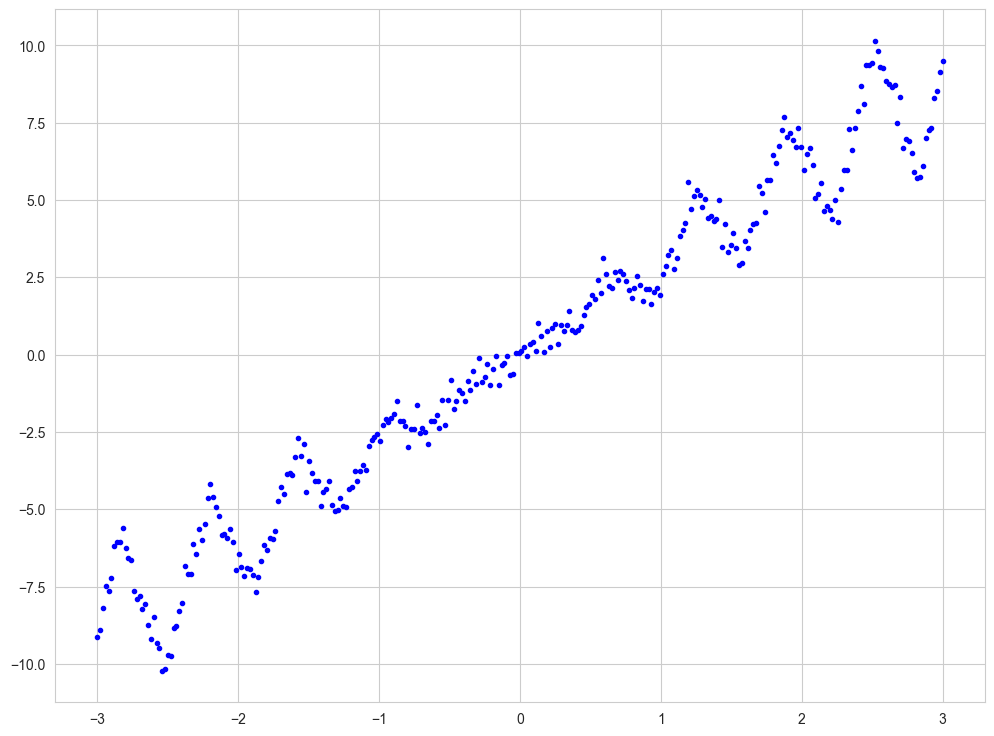

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [4]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

In [5]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

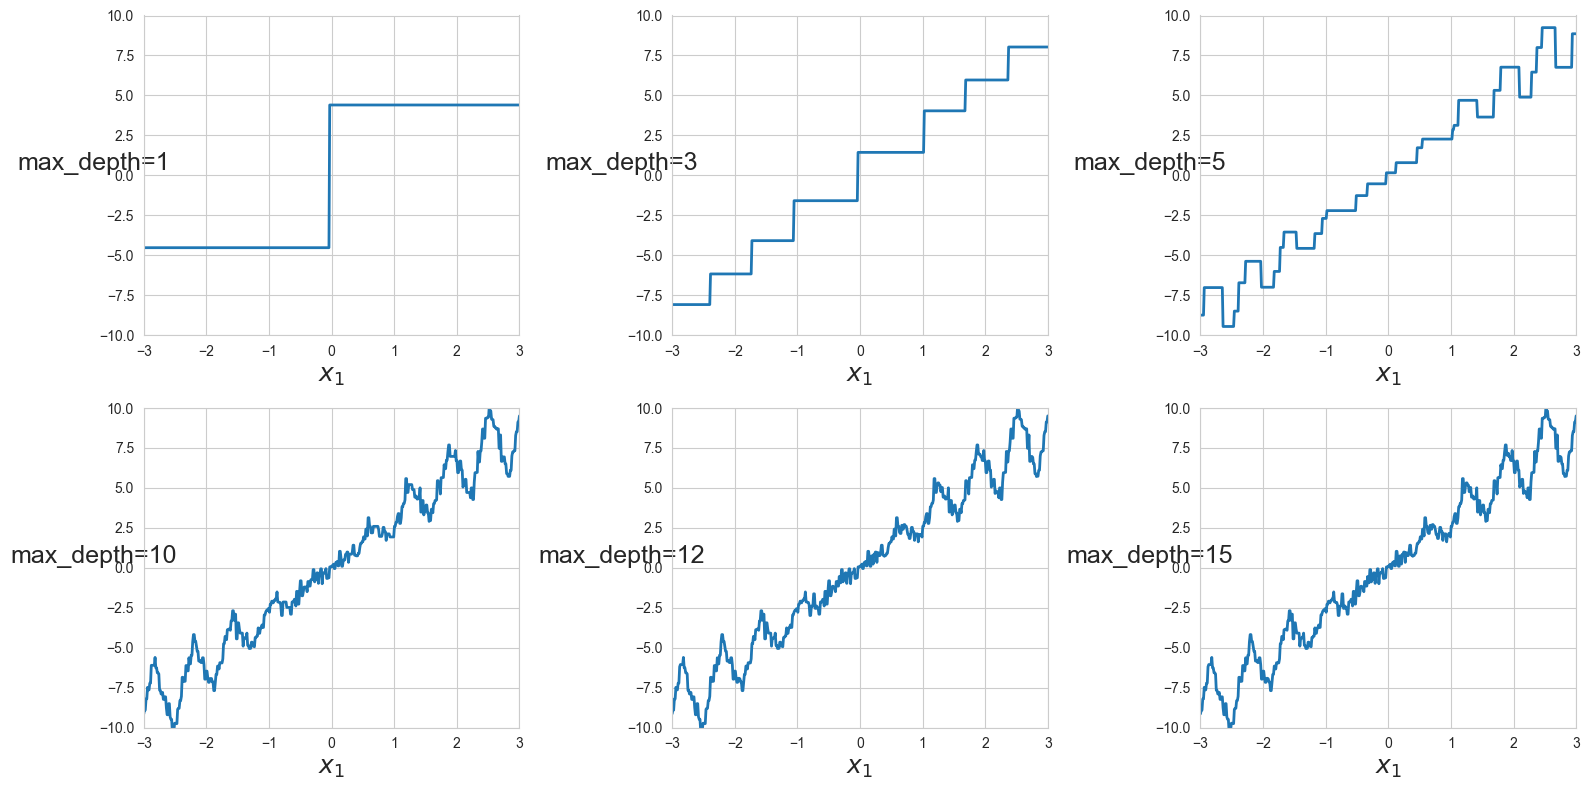

In [6]:
max_depths = [1, 3, 5, 10, 12, 15]
plt.figure(figsize=(16, 8))
for i, max_depth in enumerate(max_depths):
    plt.subplot(2, len(max_depths)//2, i+1)

    tree_reg = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    tree_reg.fit(X, y)
    plot_regression_predictions(tree_reg, X, y, ylabel=("max_depth=%d" % max_depth))

plt.tight_layout()
plt.show()

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [7]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

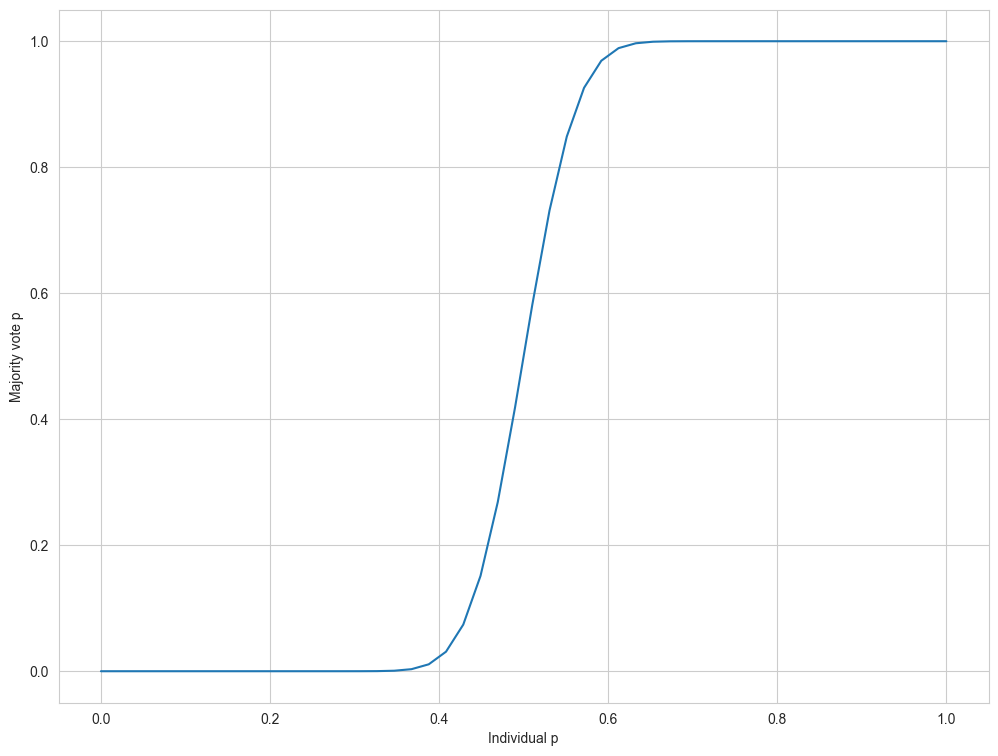

In [8]:
ps = np.linspace(0, 1, 50)
y = []

for p in ps:
    mu = 0
    for i in range(51, 101 + 1):
        mu += (mt.factorial(101) / (mt.factorial(i) * mt.factorial(101 - i))) * (p**i) * ((1.0 - p)**(101 - i))
    y.append(mu)

plt.xlabel('Individual p')
plt.ylabel('Majority vote p')
plt.plot(ps, y)
plt.show()

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [9]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

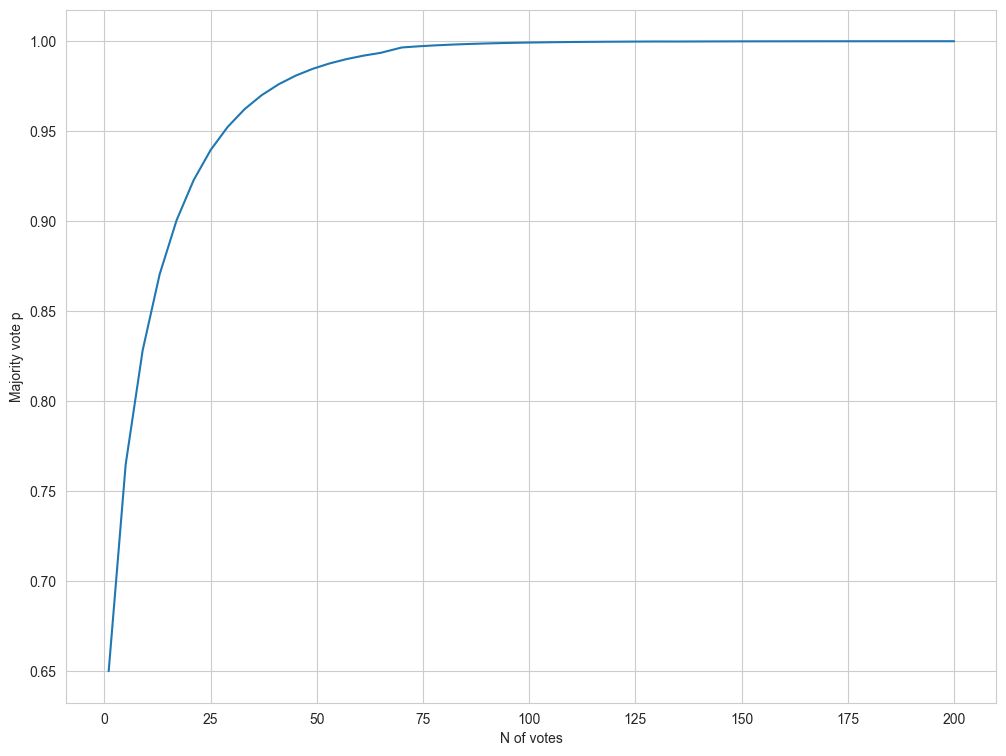

In [10]:
ns_cls = list(map(int, np.linspace(1,200,50)))
y = []
p = 0.65
for n_cls in ns_cls:
    mu = 0
    for i in range(n_cls//2 + n_cls%2,n_cls+1):
        mu += (mt.factorial(n_cls)/(mt.factorial(i)*mt.factorial(n_cls-i))) * (p**i) * ((1.0 - p)**(n_cls-i))
    y.append(mu)
    
plt.xlabel('N of votes')
plt.ylabel('Majority vote p')
plt.plot(ns_cls,y);

Опишите ваши наблюдения:

* Видно, что при росте вероятности верной классификации моделей в ансамблях вероятность верной оценки тоже будет увеличивается;
* Заметим, что чем выше количество классификаторов в ансамбле (до 75 где-то) у нас растет точность предсказания, но после выходит на плато.

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [11]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=None
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        n_samples, n_features = X.shape

        for i in range(self.n_estimators):
            np.random.seed(self.random_state + i)

            # Choose max_features without replacement
            feat_ids = np.random.choice(range(n_features), size=self.max_features, replace=False)
            self.feat_ids_by_tree.append(feat_ids)

            # Create bootstrap sample
            sample_indices = np.random.choice(range(n_samples), size=n_samples, replace=True)
            X_bootstrap = X[sample_indices][:, feat_ids]
            y_bootstrap = y[sample_indices]

            # Train decision tree
            tree = DecisionTreeClassifier(max_depth=self.max_depth, random_state=self.random_state)
            tree.fit(X_bootstrap, y_bootstrap)
            self.trees.append(tree)

        return self

    def predict_proba(self, X):
        probas = np.zeros((X.shape[0], len(self.classes_)))

        for tree, feat_ids in zip(self.trees, self.feat_ids_by_tree):
            X_subset = X[:, feat_ids]
            tree_probas = tree.predict_proba(X_subset)
            probas += tree_probas

        probas /= self.n_estimators
        return probas

    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        return predictions


Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [12]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

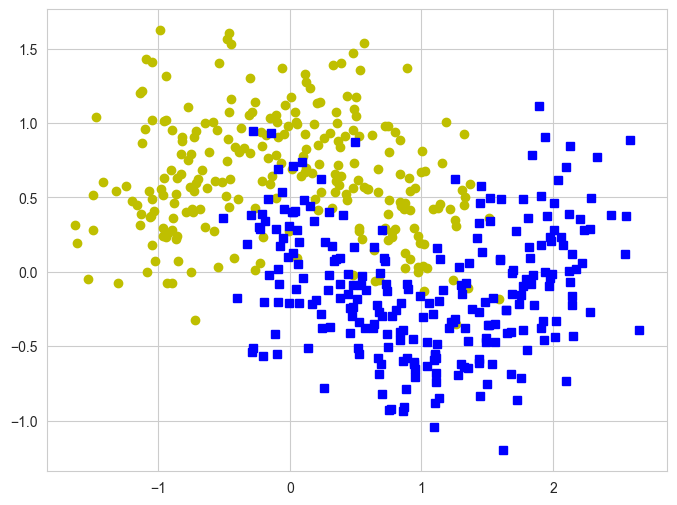

In [13]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

In [14]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

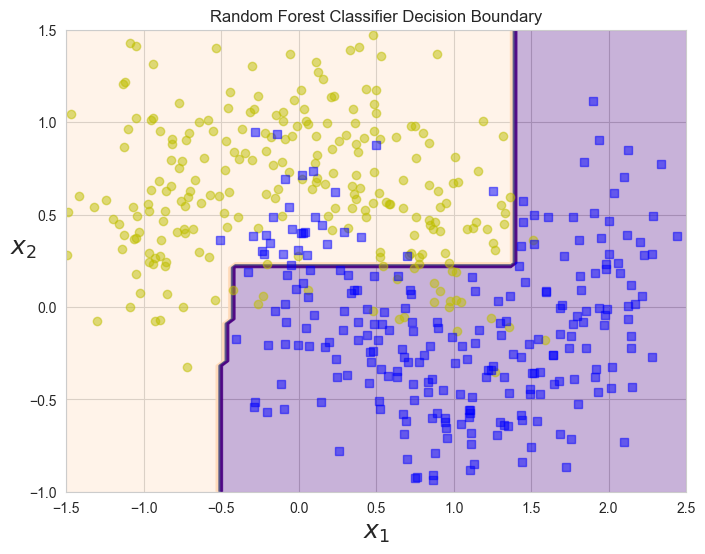

Accuracy: 0.84


In [15]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the random forest classifier
forest_clf = RandomForestClassifierCustom(n_estimators=100, max_depth=3, max_features=2, random_state=SEED)
forest_clf.fit(X_train, y_train)

# Plot the decision boundary
plt.figure(figsize=(8, 6))
plot_decision_boundary(forest_clf, X, y)
plt.title("Random Forest Classifier Decision Boundary")
plt.show()

# Calculate accuracy on the test set
y_pred = forest_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [16]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

Best Parameters: {'max_depth': 5, 'max_features': 2, 'n_estimators': 50}


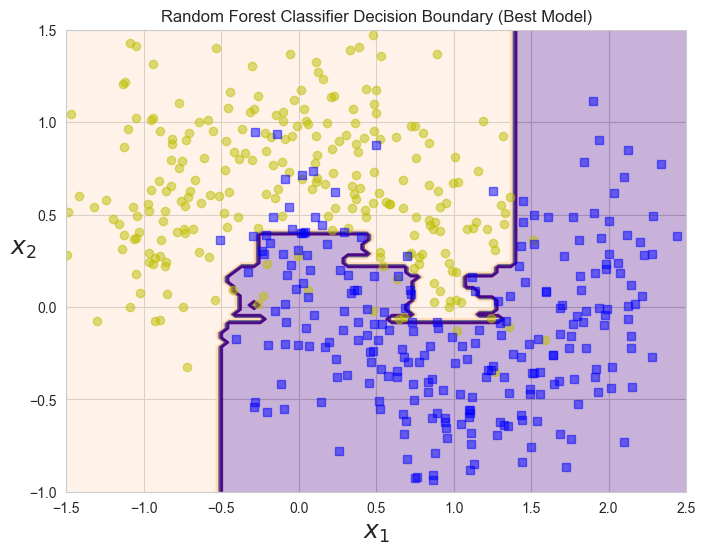

In [17]:
param_grid = {
    'n_estimators': [50, 100, 200], # я перебирала различные параметры, но 50 все равно лучший
    'max_depth': [3, 5, 7, 10, None],
    'max_features': [1, 2]
}

grid_search = GridSearchCV(RandomForestClassifierCustom(random_state=SEED), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_forest_clf = grid_search.best_estimator_

plt.figure(figsize=(8, 6))
plot_decision_boundary(best_forest_clf, X, y)
plt.title("Random Forest Classifier Decision Boundary (Best Model)")
plt.show()

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [18]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [19]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [20]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

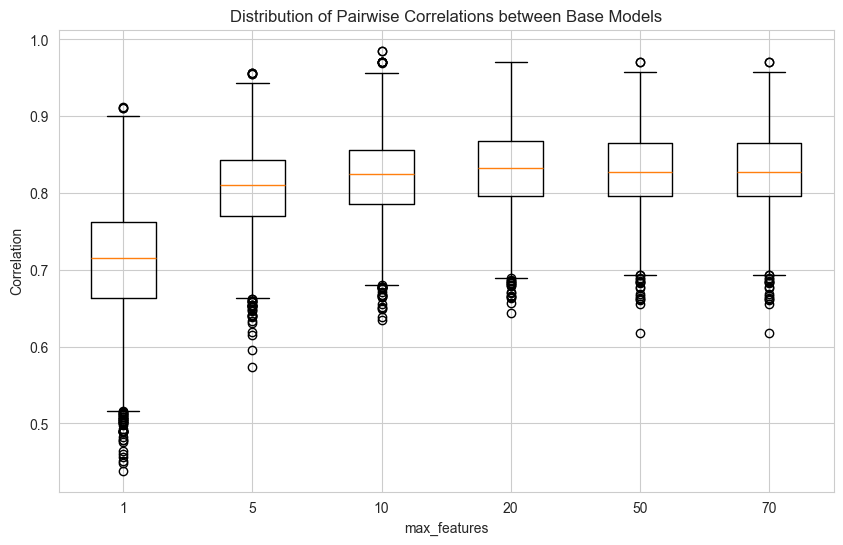

In [21]:
max_features_values = [1, 5, 10, 20, 50, 70]

correlation_values = []

for max_features in max_features_values:
    forest = RandomForestClassifier(n_estimators=100, max_features=max_features, random_state=42)
    forest.fit(X_train, y_train)
    correlations = base_model_pair_correlation(forest, X_test)
    correlation_values.append(correlations)

plt.figure(figsize=(10, 6))
plt.boxplot(correlation_values, labels=max_features_values)
plt.title('Distribution of Pairwise Correlations between Base Models')
plt.xlabel('max_features')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [22]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

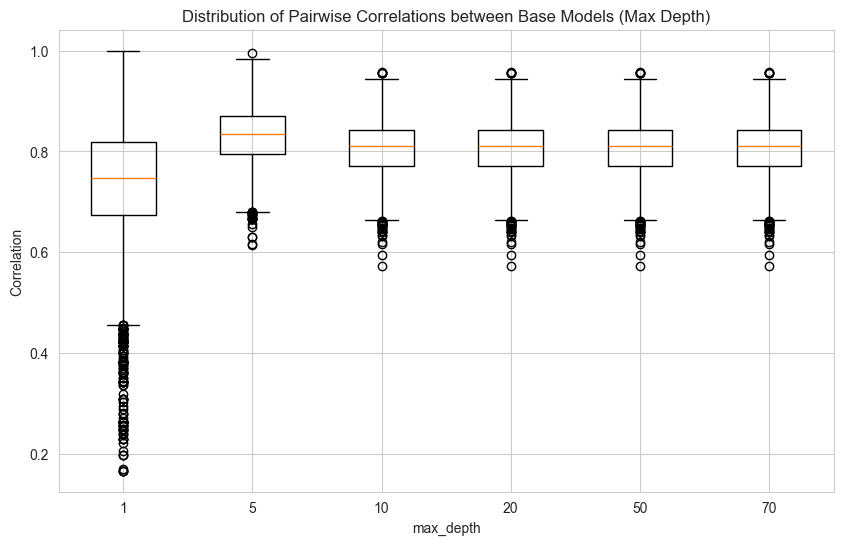

In [23]:
max_depth_values = [1, 5, 10, 20, 50, 70]

correlation_values_depth = []

for max_depth in max_depth_values:
    forest = RandomForestClassifier(n_estimators=100, max_depth=max_depth, random_state=42)
    forest.fit(X_train, y_train)
    correlations = base_model_pair_correlation(forest, X_test)
    correlation_values_depth.append(correlations)

plt.figure(figsize=(10, 6))
plt.boxplot(correlation_values_depth, labels=max_depth_values)
plt.title('Distribution of Pairwise Correlations between Base Models (Max Depth)')
plt.xlabel('max_depth')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()

Опишите ваши наблюдения:

* При увеличении признаков (параметр max_features_values) корреляция, соответственно, тоже возрастает, однако после определенного количества (20 в моем случае) не изменяется, т.е. выходит на плато.
* При увеличении глубины (параметр max_depth_values) наблюдается схожий эффект, то есть корреляция растет до определенного значения (в моем случае 5), после чего немного уменьшается и выходит на плато.

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [24]:
!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("../data/heart.csv")

"gdown" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [25]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [26]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(verbosity=-1, random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(verbosity=-1, boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [27]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting = 'soft')


## END YOUR CODE HERE ##

for model in [dt, rf, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
ExtraTreesClassifier: 0.8281746031746032
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.8134522115571786
LGBMClassifier: 0.817010631644778
XGBRFClassifier: 0.8463991769547325
LGBMClassifier: 0.8132478632478634
LogisticRegression: 0.8500073681108163
GaussianNB: 0.8140676625250128
VotingClassifier: 0.8445754787218203
VotingClassifier: 0.8503633581946834


Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [28]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [29]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [30]:
models_to_train = [dt, rf, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb]
for model in models_to_train:
    model.fit(X_train, y_train)

voting_soft_cls = VotingClassifier(estimators=base_models, voting='soft')
voting_soft_cls.fit(X_train, y_train)

correlations = base_model_pair_correlation_for_voting_clf(voting_soft_cls, X_test)

correlations_df = pd.DataFrame(correlations, columns=['Model 1', 'Model 2', 'Corr'])

models_count = correlations_df.sort_values('Corr', ascending=False).head(10)[['Model 1', 'Model 2']].stack().reset_index()
models_count[0].map(lambda x: str(x).split('(')[0]).value_counts()

0
<catboost.core.CatBoostClassifier object at 0x0000022CDD00DB10>    5
LGBMClassifier                                                     4
XGBRFClassifier                                                    4
XGBClassifier                                                      2
RandomForestClassifier                                             2
ExtraTreesClassifier                                               1
SVC                                                                1
LogisticRegression                                                 1
Name: count, dtype: int64

In [31]:
print(correlations)

[(DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111), RandomForestClassifier(n_estimators=50, random_state=111), 0.8134894007824364), (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111), ExtraTreesClassifier(random_state=111), 0.7749544834941163), (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111), KNeighborsClassifier(weights='distance'), 0.31332949662835446), (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111), SVC(kernel='linear', probability=True, random_state=111), 0.715376472596946), (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111), SVC(probability=True, random_state=111), 0.28201353566953785), (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111), <catboost.core.CatBoostClassifier object at 0x0000022CDD00DB10>, 0.7875690140798687), (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111), LGBMClassifier(random

In [32]:
[i for i in correlations if i[2] > 0.95 ]

[(ExtraTreesClassifier(random_state=111),
  0.9527199736215165),
 (SVC(kernel='linear', probability=True, random_state=111),
  LogisticRegression(max_iter=10000, solver='liblinear'),
  0.9521587740375619),
 (<catboost.core.CatBoostClassifier at 0x22cdd00db10>,
  LGBMClassifier(random_state=111, verbosity=-1),
  0.9552781313087828),
 (LGBMClassifier(random_state=111, verbosity=-1),
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=n

Уберем модели с высокой корреляцией:

In [33]:
correlation_threshold = 0.95

models_to_remove = set()

for idx, row in correlations_df.iterrows():
    if row['Corr'] > correlation_threshold:
        models_to_remove.add(row['Model 1'].__class__.__name__)

filtered_models_to_train = [model for model in models_to_train if model.__class__.__name__ not in models_to_remove]

for model in filtered_models_to_train:
    print(model.__class__.__name__)

DecisionTreeClassifier
RandomForestClassifier
KNeighborsClassifier
XGBClassifier
XGBRFClassifier
LogisticRegression
GaussianNB


Как мы видим, значение F1-score стало 0.85, что не такое, как хотелось бы:

In [34]:
models_set = [("DT", dt),("RF", rf),("KNN", knn), ("XGB_RF", xgb_rf), ("NB", nb)]

for voting in ['soft', 'hard']:
    voting_cls = VotingClassifier(estimators=models_set, voting=voting, n_jobs=-1)
    voting_cls.fit(X_train, y_train)

    scores = cross_val_score(voting_cls, X_train, y_train, cv=3, scoring="f1")

    y_pred = voting_cls.predict(X_test)
    f1 = f1_score(y_test, y_pred)

    print(f'{voting}_F1: {f1}')

soft_F1: 0.8543689320388349
hard_F1: 0.8514851485148515


Дальше я решила перебрать на абум, но ничего хорошего не вышло из этого :(

In [35]:
models_set = [("RF", rf),("KNN", knn), ("XGB_RF", xgb_rf), ("NB", nb), ("LGBM", lgbm)]

for voting in ['soft', 'hard']:
    voting_cls = VotingClassifier(estimators=models_set, voting=voting, n_jobs=-1)
    voting_cls.fit(X_train, y_train)

    scores = cross_val_score(voting_cls, X_train, y_train, cv=3, scoring="f1")

    y_pred = voting_cls.predict(X_test)
    f1 = f1_score(y_test, y_pred)

    print(f'{voting}_F1: {f1}')

soft_F1: 0.8627450980392157
hard_F1: 0.8514851485148515


In [36]:
models_set = [("XGB_RF", xgb_rf), ("NB", nb), ("LGBM", lgbm), ("CAT", cat)]

for voting in ['soft', 'hard']:
    voting_cls = VotingClassifier(estimators=models_set, voting=voting, n_jobs=-1)
    voting_cls.fit(X_train, y_train)

    scores = cross_val_score(voting_cls, X_train, y_train, cv=3, scoring="f1")

    y_pred = voting_cls.predict(X_test)
    f1 = f1_score(y_test, y_pred)

    print(f'{voting}_F1: {f1}')

soft_F1: 0.8627450980392157
hard_F1: 0.88


In [37]:
# from itertools import combinations

# base_models = [("DT", dt), ("RF", rf), 
#                ("ETC", etc), ("KNN", knn), 
#                ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
#                ("CAT", cat), ("LGBM", lgbm), 
#                ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
#                ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

# target_f1_score = 0.87

# all_combinations = []
# for r in range(1, len(base_models) + 1):
#     all_combinations.extend(combinations(base_models, r))

# best_voting_cls = None
# best_f1_score = 0

# for combination in all_combinations:
#     models_set = list(combination)

#     for voting in ['soft', 'hard']:
#         voting_cls = VotingClassifier(estimators=models_set, voting=voting, n_jobs=-1)
#         voting_cls.fit(X_train, y_train)

#         scores = cross_val_score(voting_cls, X_train, y_train, cv=3, scoring="f1")

#         y_pred = voting_cls.predict(X_test)
#         f1 = f1_score(y_test, y_pred)

#         if f1 > best_f1_score:
#             best_f1_score = f1
#             best_voting_cls = voting_cls

#         print(f'===== Combination: {combination} Voting: {voting=} =====')
#         print(f'{voting}_F1: {f1}')

# print(f'Best combination: {best_voting_cls.estimators_}, {best_f1_score=}')

Посмотрим на комбинацию из рандомного леса, lgbm, линейной регрессии, GaussianNB

In [38]:
models_set = [('RF', rf),
                ("LGBM", lgbm), 
                ("LR", lr), 
                ("NB", nb)]

for voting in ['soft', 'hard']:
    voting_cls = VotingClassifier(estimators=models_set, voting=voting, n_jobs=-1)
    voting_cls.fit(X_train, y_train)

    scores = cross_val_score(voting_cls, X_train, y_train, cv=3, scoring="f1")

    y_pred = voting_cls.predict(X_test)
    f1 = f1_score(y_test, y_pred)

    print(f'{voting}_F1: {f1}')

soft_F1: 0.8712871287128713
hard_F1: 0.9072164948453608


Ну, вроде нормально...

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [39]:
data = pd.read_csv("../data/churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


### EDA:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

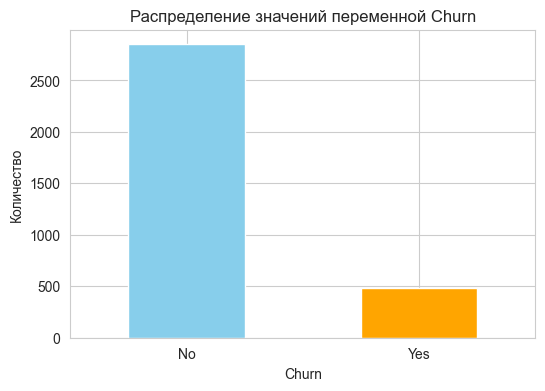

In [40]:
data.info()

print("\n")

missing_values = data.isnull().sum()

print("Пропущенные значения в данных:")
print(missing_values)
print("\n")

plt.figure(figsize=(6, 4))
data['Churn?'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Распределение значений переменной Churn')
plt.xlabel('Churn')
plt.ylabel('Количество')
plt.xticks([0, 1], ['No', 'Yes'], rotation=0)
plt.show()

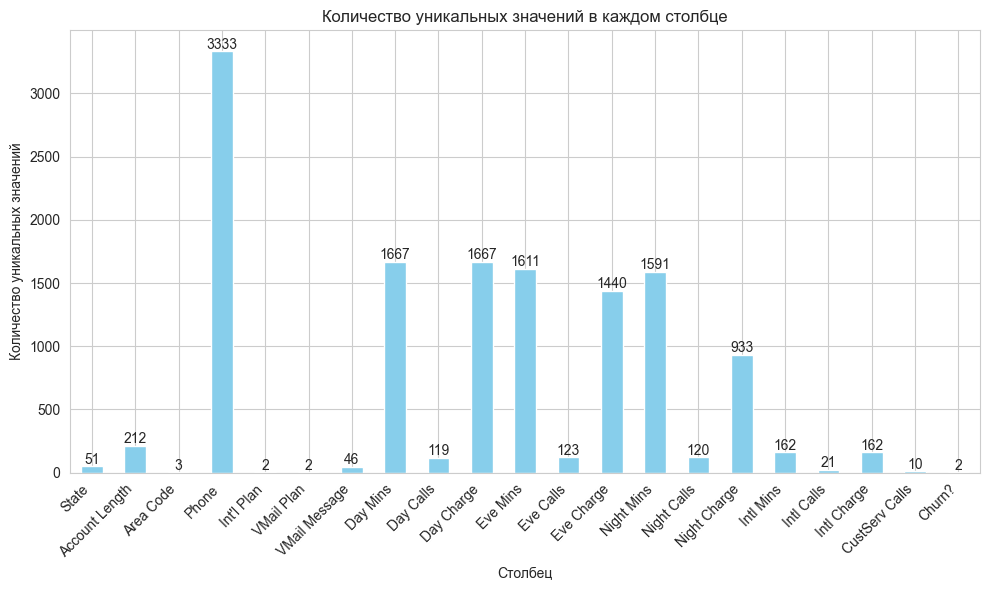

In [41]:
unique_counts = data.nunique()

plt.figure(figsize=(10, 6))
unique_counts.plot(kind='bar', color='skyblue')
plt.title('Количество уникальных значений в каждом столбце')
plt.xlabel('Столбец')
plt.ylabel('Количество уникальных значений')

for i, count in enumerate(unique_counts):
    plt.text(i, count + 20, str(count), ha='center')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

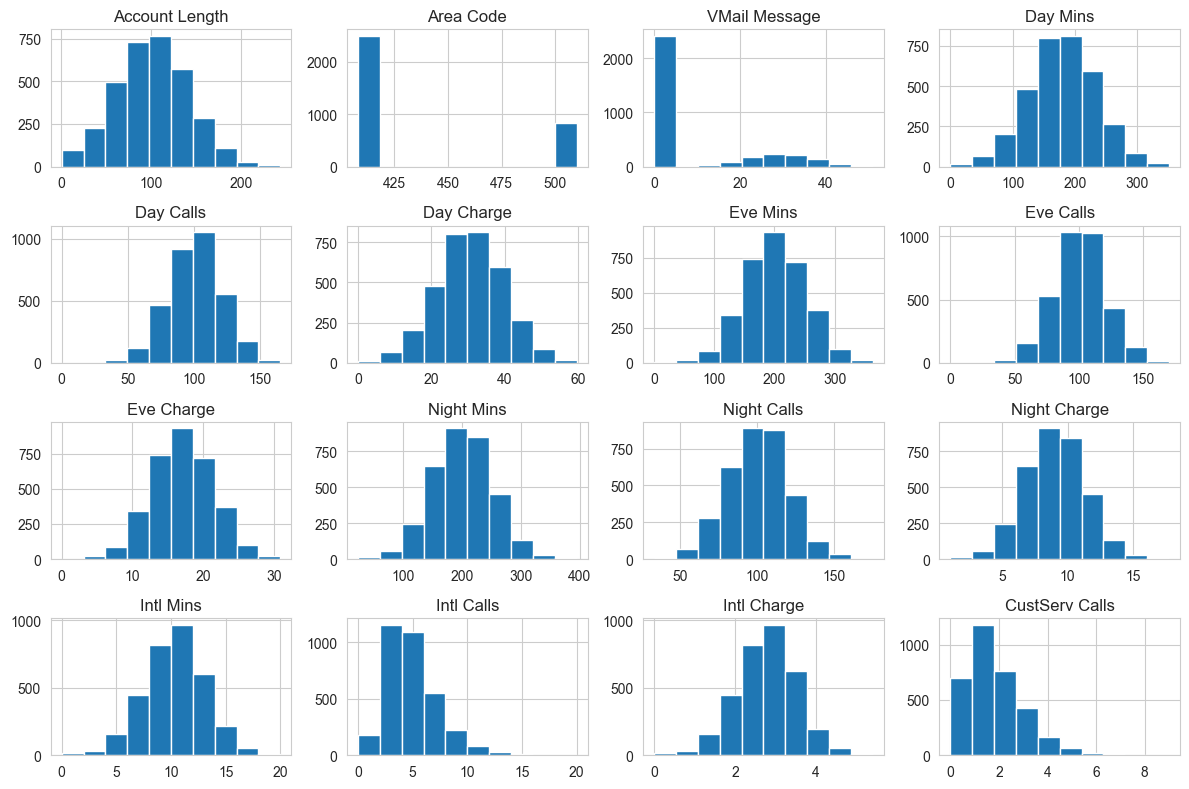

In [42]:
data.hist(figsize=(12, 8))
plt.tight_layout()
plt.show()

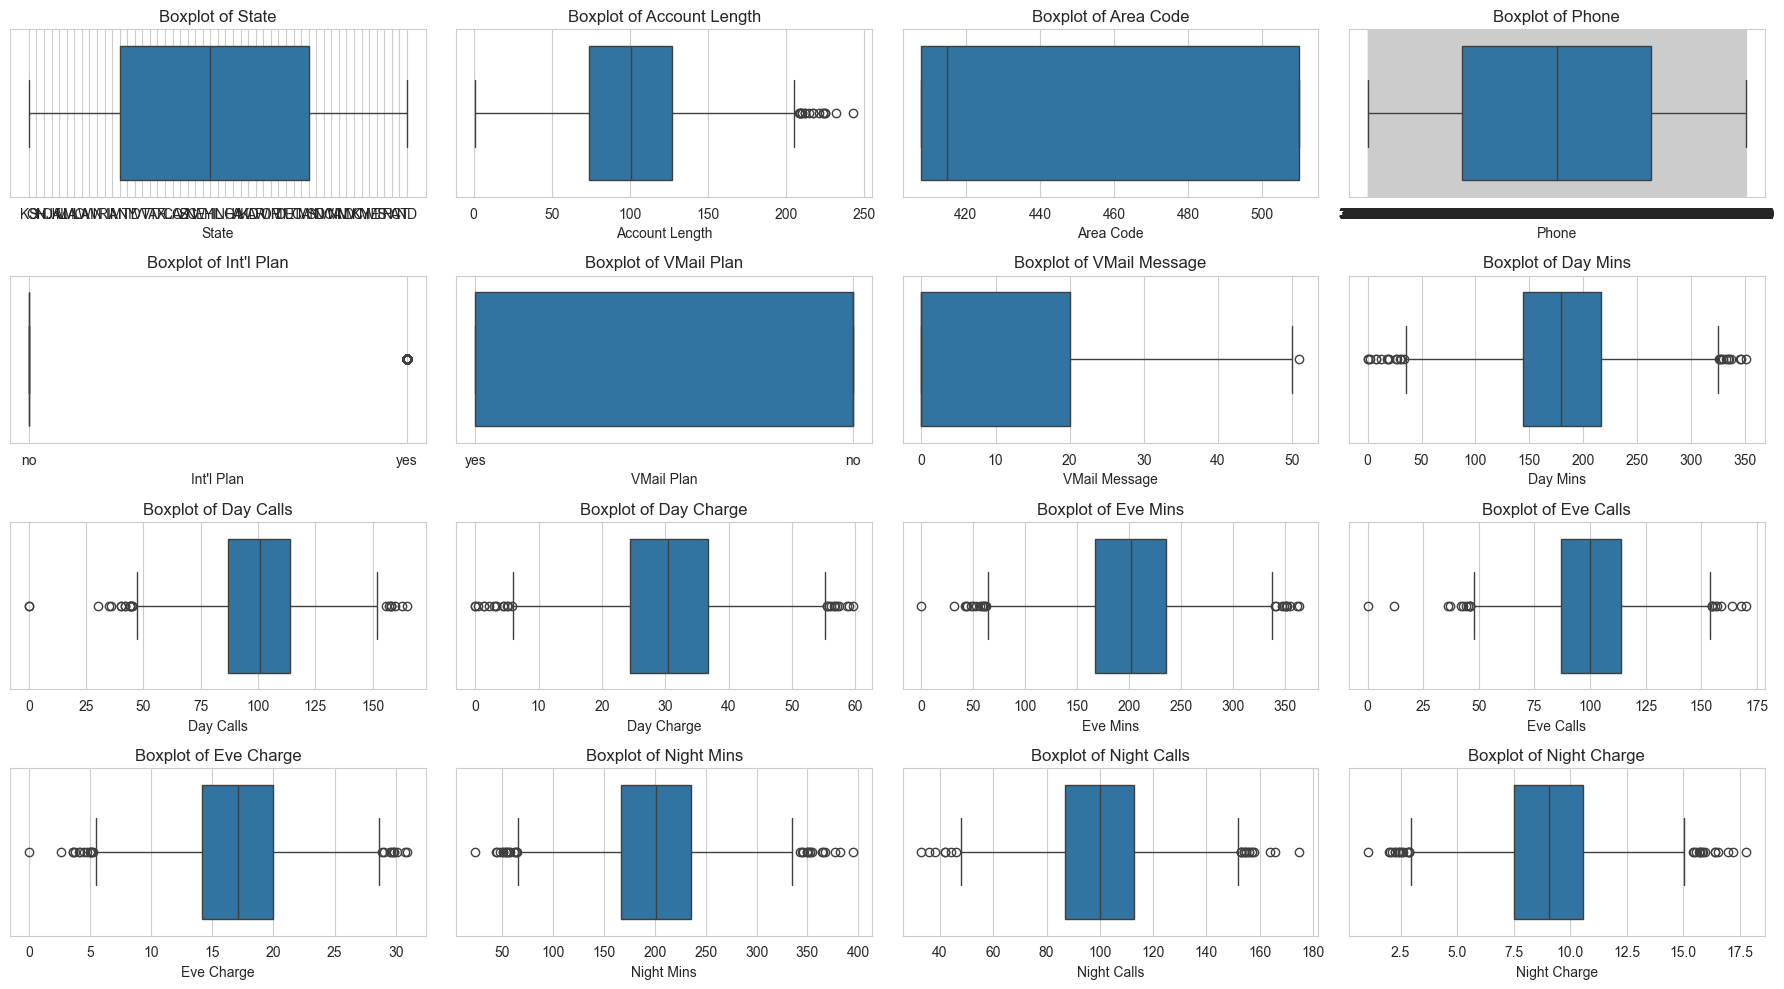

In [43]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(18, 10))

for ax, column in zip(axes.flatten(), data.columns):
    sns.boxplot(x=data[column], ax=ax)
    ax.set_title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

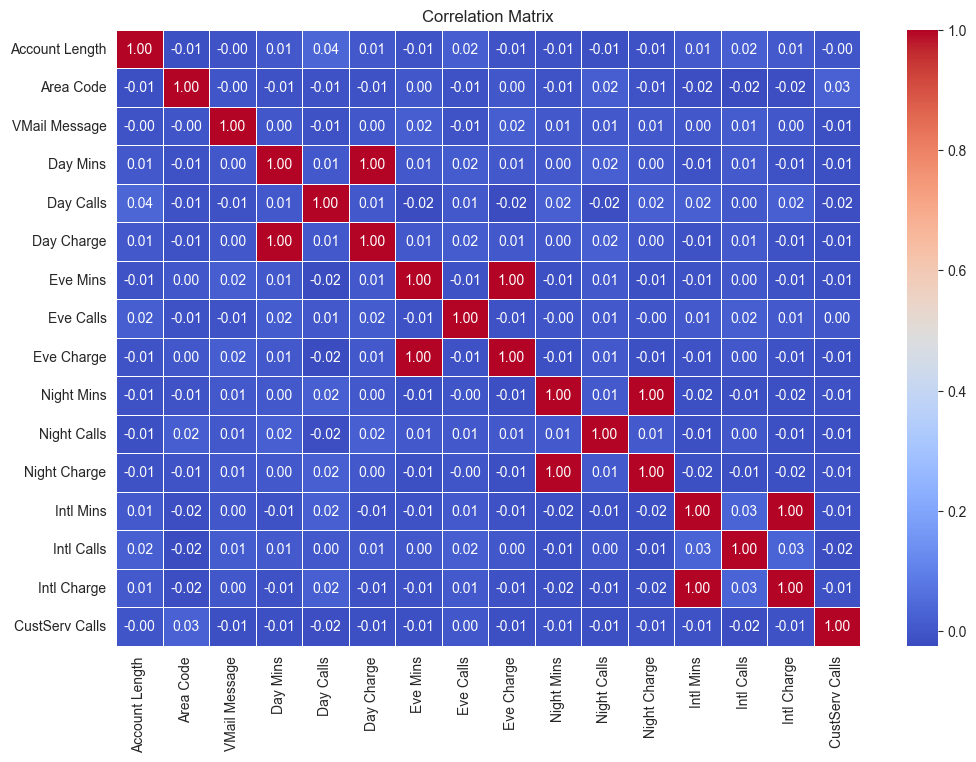

In [44]:
numeric_columns = data.select_dtypes(include=['int64', 'float64'])
corr_matrix = numeric_columns.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Предлагаю дропнуть признаки, которые коррелируют и не особо влияют на предсказания, типа номера телефона, так как количество уникальных значений = количесвтву пользователям:

In [45]:
data = data.drop(['Phone', 'Area Code', 'Day Mins', 'Eve Mins', 'Night Mins','Intl Mins'], axis=1)

In [46]:
num_features = ['Account Length', 'VMail Message', 'Day Charge', 'Day Calls', 
                'Eve Charge', 'Eve Calls',  'Night Charge', 'Night Calls', 
                'Intl Charge', 'Intl Calls', 'CustServ Calls']
cat_features = ['State']
bool_features = ["Int'l Plan", "VMail Plan"]

for feature in bool_features:
    data[feature] = data[feature].map({'no': 0, 'yes': 1})

In [47]:
# Я долго думала, что за фигня с перекодировкой в 0 и 1 False и True... 
X = data.drop(['Churn?'], axis = 1)
y = data['Churn?'].map({'False.': 0, 'True.': 1})

In [48]:
preprocessor = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), num_features),
    ('ohe', OneHotEncoder(), cat_features)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

### XGBClassifier Model

In [49]:
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', XGBClassifier(random_state=SEED))
])

xgb_param_grid = {
    'xgb__n_estimators': [100, 200, 300],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.1, 0.01, 0.001]
}

xgb_grid_search = GridSearchCV(estimator=xgb_pipeline, param_grid=xgb_param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

xgb_grid_search.fit(X_train, y_train)

print("Best parameters XGBClassifier:", xgb_grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters XGBClassifier: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 100}


Accuracy: 0.9265367316341829


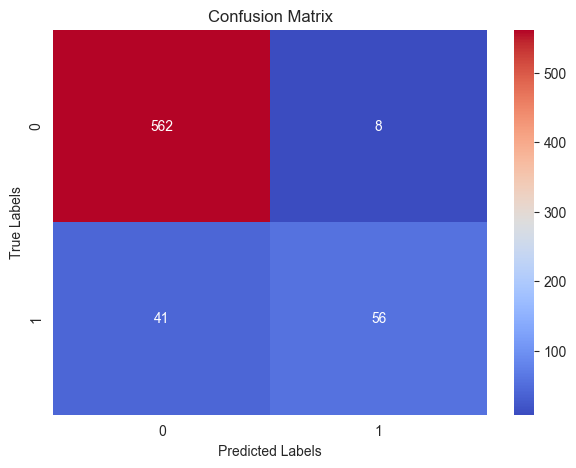

In [50]:
y_pred_xgb = xgb_grid_search.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

print("Accuracy:", accuracy_xgb)

plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix_xgb, annot=True, fmt="d", cmap="coolwarm", cbar=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Грустно и невкусно

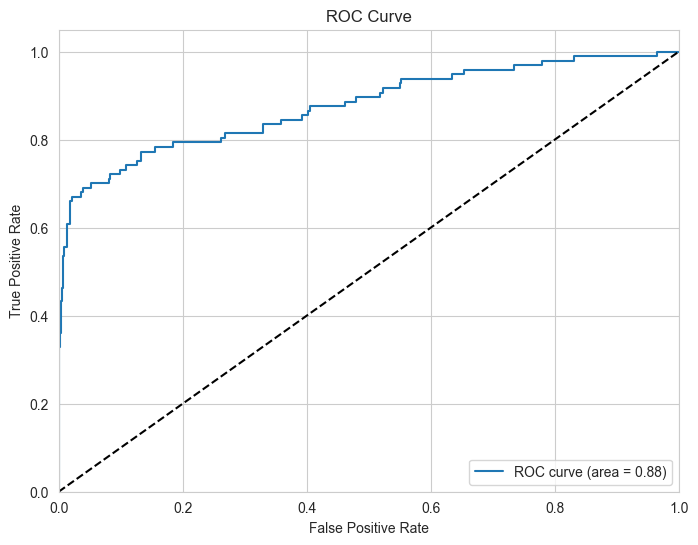

In [51]:
def plot_roc_curve(y_true, y_pred_proba):
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    plt.rcParams["figure.figsize"] = 8, 6
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

y_pred_proba_xgb = xgb_grid_search.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_pred_proba_xgb)

### LGBMClassifier с boosting_type="rf"

In [52]:
lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lgbm', LGBMClassifier(boosting_type="rf", random_state=SEED, verbosity=-1))
])

param_grid_lgbrf = {
    'lgbm__bagging_fraction': [0.5, 0.7, 0.9],
    'lgbm__feature_fraction': [0.5, 0.7, 0.9],
    'lgbm__bagging_freq': [1, 5, 10]
}

grid_search_lgbrf = GridSearchCV(estimator=lgbm_pipeline, param_grid=param_grid_lgbrf, scoring='f1', cv=3)
grid_search_lgbrf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         ['Account '
                                                                          'Length',
                                                                          'VMail '
                                                                          'Message',
                                                                          'Day '
                                                                          'Charge',
                                                                          'Day '
                                                                          'Calls',
                                                                          'Eve '
                                                                          'Charge',
                                                                          'Eve '
                                                                          'Calls',
                                                                          'Night '
                                                                          'Charge',
                                                                          'Night '
                                                                          'Calls',
                                                                          'Intl '
                                                                          'Charge',
                                                                          'Intl '
                                                                          'Calls',
                                                                          'CustServ '
                                                                          'Calls']),
                                                                        ('ohe',
                                                                         OneHotEncoder(),
                                                                         ['State'])])),
                                       ('lgbm',
                                        LGBMClassifier(boosting_type='rf',
                                                       random_state=111,
                                                       verbosity=-1))]),
             param_grid={'lgbm__bagging_fraction': [0.5, 0.7, 0.9],
                         'lgbm__bagging_freq': [1, 5, 10],
                         'lgbm__feature_fraction': [0.5, 0.7, 0.9]},
             scoring='f1')

Accuracy: 0.9115442278860569


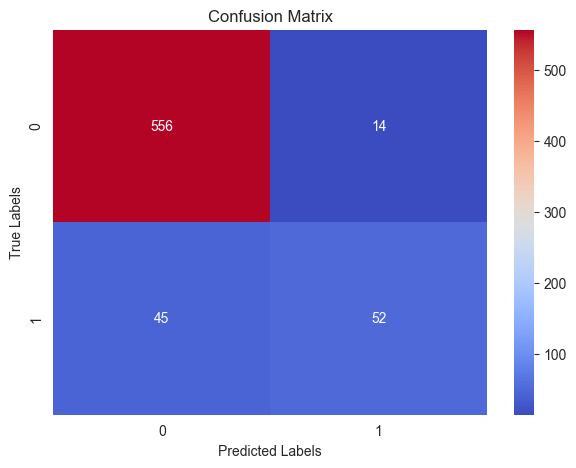

In [53]:
y_pred_lgbrf = grid_search_lgbrf.predict(X_test)

accuracy_lgbrf = accuracy_score(y_test, y_pred_lgbrf)
print("Accuracy:", accuracy_lgbrf)

conf_matrix_lgbrf = confusion_matrix(y_test, y_pred_lgbrf)
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix_lgbrf, annot=True, fmt="d", cmap="coolwarm", cbar=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

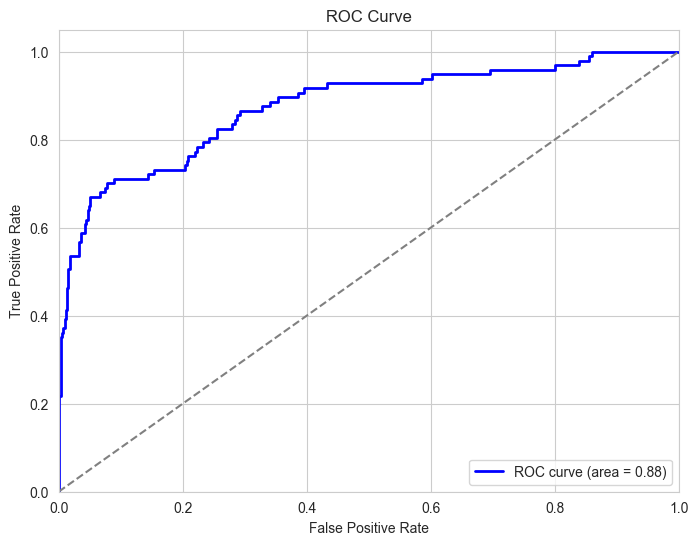

ROC-AUC: 0.8751130403327907


In [54]:
y_pred_proba_lgbrf = grid_search_lgbrf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_lgbrf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print("ROC-AUC:", roc_auc)


В общем, в данных наблюдается дисбаланс, поэтому чтобы улучшить предсказания наших моделей необходимо с этим разобраться, но это в следующей жизни :)

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [55]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

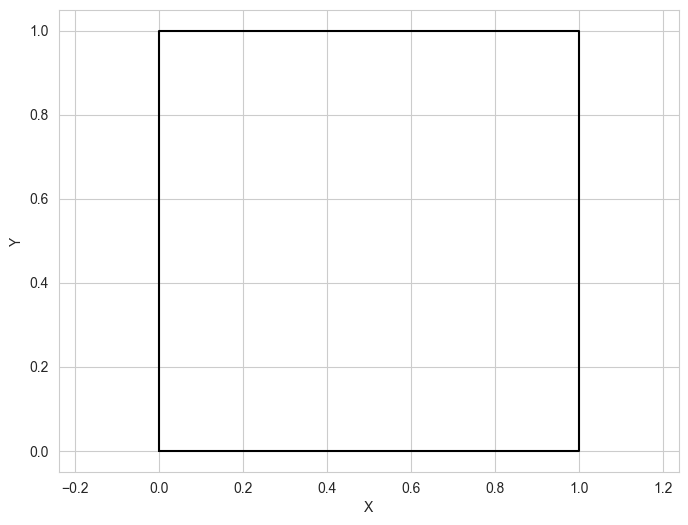

In [56]:
x = [0, 1, 1, 0, 0]
y = [0, 0, 1, 1, 0]

plt.plot(x, y, color='black')

plt.xlabel('X')
plt.ylabel('Y')

plt.grid(True)
plt.axis('equal')
plt.show()

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**